In [13]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from PIL import Image

In [18]:
c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
c2=sns.color_palette()[2]

In [19]:
from matplotlib.colors import ListedColormap

In [21]:
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.1, psize=10, zfunc=False, predicted=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if zfunc:
        p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
        p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z=zfunc(p0, p1)
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = Z.reshape(xx.shape)
    if mesh:
        plt.pcolormesh(xx, yy, ZZ, cmap=cmap_light, alpha=alpha, axes=ax)
    if predicted:
        showtr = clf.predict(Xtr)
        showte = clf.predict(Xte)
    else:
        showtr = ytr
        showte = yte
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=showtr-1, cmap=cmap_bold, s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    ax.scatter(Xte[:, 0], Xte[:, 1], c=showte-1, cmap=cmap_bold, alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

In [22]:
def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, colorscale=colorscale, cdiscrete=cdiscrete, psize=psize, alpha=alpha, predicted=True) 
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    return ax 

## Using sklearn: The heights and weights example¶


In [23]:
data = pd.read_csv("01_heights_weights_genders.csv")
data.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


In [36]:
male = data[data.Gender == 'Male']
female = data[data.Gender == 'Female']

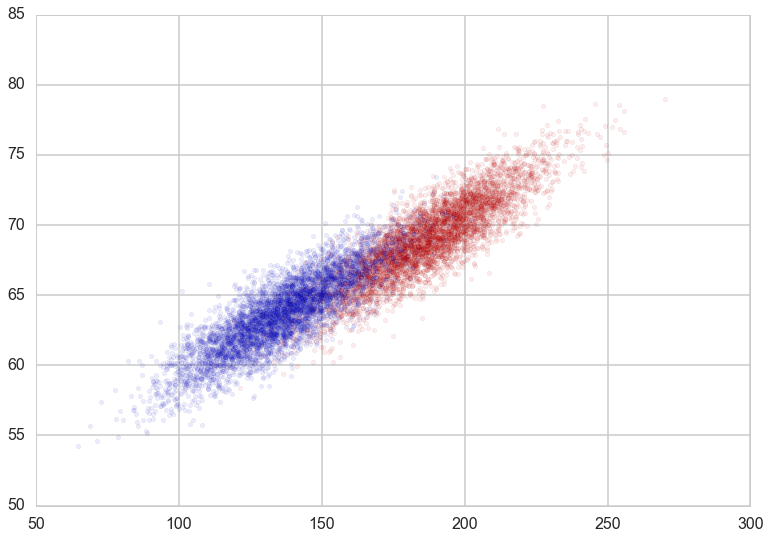

In [40]:
plt.scatter(male.Weight, male.Height, c = cm_bright.colors[0], alpha = 0.08)
plt.scatter(female.Weight, female.Height, alpha = 0.08)

In [83]:
from sklearn.cross_validation import KFold
from sklearn.metrics import accuracy_score
#clf is the classification model.
def cv_score(clf, x, y, score_func=accuracy_score):
    #print (x.size)
    result = 0
    nfold = 5
    #here the actuall crossvalidation is taking place.
    #and the test here is actually validation set, Kfold does all our work.
    for train, test in KFold(y.size, nfold):# split data into train/test groups, 5 times
        clf.fit(x[train], y[train])# fit
        result += score_func(clf.predict(x[test]), y[test])# evaluate score function on held-out data
    return result/nfold# average

In [90]:
from sklearn.cross_validation import train_test_split
#here we split the data in actual train and test data.
Xlr, Xtestlr, ylr, ytestlr = train_test_split(data[['Height','Weight']].values, (data.Gender=="Male").values)
#print (Xlr.size, Xtestlr.size, ylr.size, ytestlr.size)
Xlr

array([[  67.93499042,  182.2710213 ],
       [  69.80157523,  203.2583751 ],
       [  69.98313746,  206.41441183],
       ..., 
       [  64.94254533,  135.38715381],
       [  63.55635371,  134.75059409],
       [  61.82336812,  112.00186173]])

0.9208 0.001


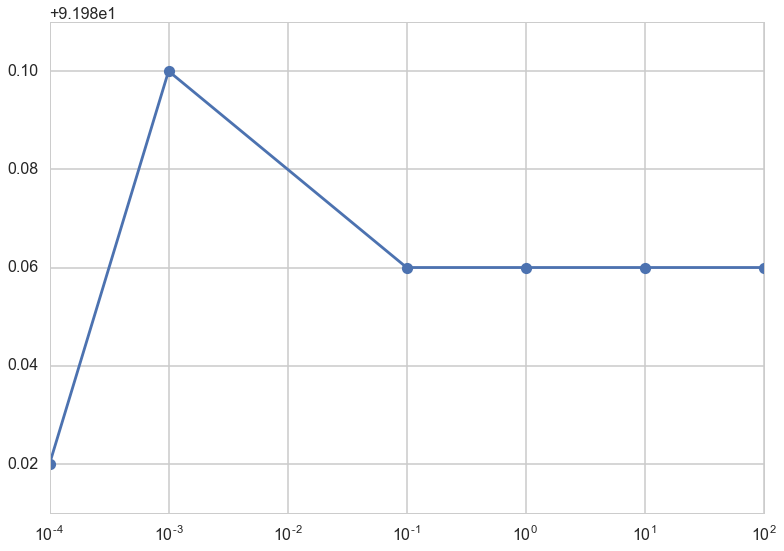

In [130]:
#the grid of parameters to search over
Cs = [0.0001, 0.001, 0.1, 1, 10, 100]
from sklearn.linear_model import LogisticRegression
max_score = 0
scores = []
for C in Cs:
    clf = LogisticRegression(C = C)
    score = cv_score(clf, Xlr, ylr)
    scores.append(score * 100)
    if(score > max_score):
        max_score = score
        best_C = C
plt.plot(Cs, scores, 'o-')
plt.xscale('log')
print (max_score, best_C)

In [131]:
clf = LogisticRegression(C = best_C)
clf.fit(Xlr, ylr)
accuracy = accuracy_score(clf.predict(Xtestlr), ytestlr)
accuracy

0.91479999999999995

Hence our model predicts the data with nearly 92.12% accuracy

## This is a direct way to do the above things

In [132]:
from sklearn.grid_search import GridSearchCV
clf2 = LogisticRegression()
params = {"C" : [0.0001, 0.001, 0.1, 1, 10, 100]}
fit_model = GridSearchCV(clf2, param_grid = params, cv = 5, scoring = "accuracy")
fit_model.fit(Xlr, ylr)
fit_model.best_estimator_, fit_model.best_params_, fit_model.best_score_, fit_model.grid_scores_

(LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 {'C': 0.001},
 0.92053333333333331,
 [mean: 0.91987, std: 0.00605, params: {'C': 0.0001},
  mean: 0.92053, std: 0.00726, params: {'C': 0.001},
  mean: 0.92013, std: 0.00699, params: {'C': 0.1},
  mean: 0.92013, std: 0.00699, params: {'C': 1},
  mean: 0.92013, std: 0.00699, params: {'C': 10},
  mean: 0.92013, std: 0.00699, params: {'C': 100}])

In [133]:
clfl2=LogisticRegression(C=fit_model.best_params_['C'])
clfl2.fit(Xlr, ylr)
score = accuracy_score(clfl2.predict(Xtestlr), ytestlr)
score

0.91479999999999995